In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from keras import models, layers, optimizers
from keras.applications.vgg16 import VGG16
from PIL import Image

In [2]:
import os

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
conv_base = VGG16(
    weights= "imagenet",
    input_shape=(384,384,3),
    include_top=False
)

In [1]:
# import resnet50
# conv_base = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(200,200,3))


ModuleNotFoundError: No module named 'resnet50'

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [6]:
resize_= keras.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [7]:
model = keras.Sequential([
    resize_,
    conv_base,
    layers.Flatten(),
    layers.Dense(126,activation='relu'),
    #add last layer with softmax for 6 possible outputs
    layers.Dense(9,activation='softmax')
])

In [8]:
conv_base.trainable = False

In [9]:
model.build((None,200,200,3))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 126)               2322558   
                                                                 
 dense_1 (Dense)             (None, 9)                 1143      
                                                                 
Total params: 17,038,389
Trainable params: 2,323,701
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
# Define the path where our dataset is stored
dataset_path = './dataset2/garbage_classification'

# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")
        
        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))
                
# Determine if all images in the entore dataset have the same dimensions 
if len(all_dimensions_set) == 1: 
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

battery folder contains 945 images.
biological folder contains 985 images.
brown-glass folder contains 607 images.
cardboard folder contains 891 images.
metal folder contains 769 images.
paper folder contains 1050 images.
plastic folder contains 865 images.
trash folder contains 697 images.
white-glass folder contains 775 images.

The images in the dataset have different dimensions or color channels.


In [12]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    for file in os.listdir(os.path.join(dataset_path, garbage_type)):
        # Append the image file path and its trash type (as a label) to the data list
        data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

,filepath,label
0,./archive/garbage_classification\battery\batte...,battery
1,./archive/garbage_classification\battery\batte...,battery
2,./archive/garbage_classification\battery\batte...,battery
3,./archive/garbage_classification\battery\batte...,battery
4,./archive/garbage_classification\battery\batte...,battery


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 6067
Number of images in the validation set: 1517


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
# train_datagen = ImageDataGenerator(
#     rescale=1./255,                     # Normalize pixel values to [0,1]
#     rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
#     width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
#     height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
#     zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
#     horizontal_flip=True,               # Randomly flip images horizontally
#     vertical_flip=True,                 # Randomly flip images vertically
#     shear_range=0.05,                   # Apply slight shear transformations
#     brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
#     channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
#     fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
# )

# val_datagen = ImageDataGenerator( rescale=1./255)

In [17]:
train_datagen= ImageDataGenerator()
val_datagen= ImageDataGenerator()

In [18]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(200, 200),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(200, 200),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)




Found 6067 validated image filenames belonging to 9 classes.
Found 1517 validated image filenames belonging to 9 classes.


In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [20]:
hist= model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    batch_size=32
)

Epoch 1/10
190/190 [==============================] - 142s 447ms/step - loss: 0.9522 - accuracy: 0.6934 - val_loss: 0.6212 - val_accuracy: 0.7851
Epoch 2/10
190/190 [==============================] - 39s 206ms/step - loss: 0.3958 - accuracy: 0.8632 - val_loss: 0.5355 - val_accuracy: 0.8279
Epoch 3/10
190/190 [==============================] - 42s 220ms/step - loss: 0.2236 - accuracy: 0.9293 - val_loss: 0.5076 - val_accuracy: 0.8233
Epoch 4/10
190/190 [==============================] - 44s 233ms/step - loss: 0.1322 - accuracy: 0.9652 - val_loss: 0.5583 - val_accuracy: 0.8141
Epoch 5/10
190/190 [==============================] - 47s 247ms/step - loss: 0.0870 - accuracy: 0.9787 - val_loss: 0.4928 - val_accuracy: 0.8359
Epoch 6/10
190/190 [==============================] - 47s 249ms/step - loss: 0.0503 - accuracy: 0.9911 - val_loss: 0.5500 - val_accuracy: 0.8167
Epoch 7/10
190/190 [==============================] - 47s 245ms/step - loss: 0.0329 - accuracy: 0.9955 - val_loss: 0.5396 - val_a

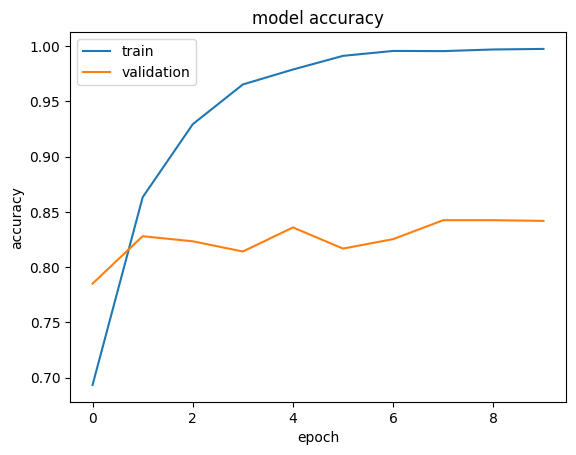

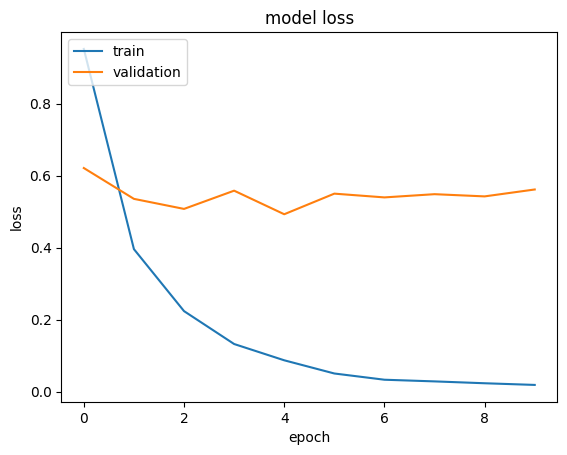

In [21]:
#create graph of accuracy and loss over time
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train","validation"],loc="upper left")
plt.show()

plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train","validation"],loc="upper left")
plt.show()



In [22]:
model.save("model_trained.h5")